In [16]:
import re
from tqdm import tqdm

import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import Dataset

import utils

# Вспомогательные функции и классы

In [3]:
CLINICAL_TERMS = {
    'ptsd': 'PTSD',
    'ocd': 'OCD',
    'adhd': 'ADHD'
}

def normalize_clinical_terms(text):
    for term, normalized in CLINICAL_TERMS.items():
        text = re.sub(rf'\b{term}\b', normalized, text, flags=re.IGNORECASE)
    return text


def preprocess_for_mentalroberta(text):
    text = utils.clean_text(text)
    text = normalize_clinical_terms(text)
    text = utils.flag_self_harm(text)
    return text

In [4]:
# Создание класса датасета
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels.tolist())
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }
    
    def __len__(self):
        return len(self.labels)

In [10]:
# Обучение модели
def train_model(epochs, model, train_loader, device, optimizer, scheduler):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Эпоха {epoch+1}/{epochs}")
        print(f"Средний лосс: {avg_train_loss:.4f}")


# Оценка на тестовой выборке
def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds = []
    test_labels = []

    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            
            test_preds.extend(logits)
            test_labels.extend(label_ids)

    return test_preds, test_labels


# Функция для вычисления точности
def compute_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.array(labels).flatten()
    return classification_report(labels_flat, preds_flat, target_names=label_map.keys())

# Подготовка датасета

In [7]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Загрузка данных
df = pd.read_csv("data/mental_health_data.csv", index_col=0)
print(f"Размер датасета: {len(df)}")
print("Классы:\n", df["status"].value_counts())

# Предобработка текста
df['cleaned_text'] = df['statement'].apply(preprocess_for_mentalroberta)

# Преобразование меток в числовой формат
label_map = {label: idx for idx, label in enumerate(df["status"].unique())}
df["label"] = df["status"].map(label_map)
print("Соответствие меток:", label_map)

# Разделение данных
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
print(f"Тренировочные данные: {len(train_df)}, Тестовые данные: {len(test_df)}")

Используемое устройство: cuda
Размер датасета: 53043
Классы:
 status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64
Соответствие меток: {'Anxiety': 0, 'Normal': 1, 'Depression': 2, 'Suicidal': 3, 'Stress': 4, 'Bipolar': 5, 'Personality disorder': 6}
Тренировочные данные: 42434, Тестовые данные: 10609


# Предобученная модель

In [19]:
# Инициализация токенизатора и модели
MODEL_NAME = "mental/mental-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_map),
    id2label={v: k for k, v in label_map.items()},
    label2id=label_map
).to(device)

/home/student/kholicheva/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
MAX_LENGTH = 256
BATCH_SIZE = 16

# Создание тестового DataLoader
test_dataset = MentalHealthDataset(test_df["cleaned_text"], test_df["label"], tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Оценка модели
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Вывод метрик
print("\nРезультаты классификации:")
report = compute_metrics(test_preds, test_labels)
print(report)

100%|██████████| 664/664 [00:36<00:00, 18.34it/s]


Результаты классификации:
                      precision    recall  f1-score   support

             Anxiety       0.00      0.00      0.00       778
              Normal       0.31      1.00      0.47      3270
          Depression       0.00      0.00      0.00      3081
            Suicidal       0.00      0.00      0.00      2131
              Stress       0.00      0.00      0.00       534
             Bipolar       0.00      0.00      0.00       575
Personality disorder       0.00      0.00      0.00       240

            accuracy                           0.31     10609
           macro avg       0.04      0.14      0.07     10609
        weighted avg       0.10      0.31      0.15     10609




/home/student/kholicheva/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/student/kholicheva/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/student/kholicheva/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

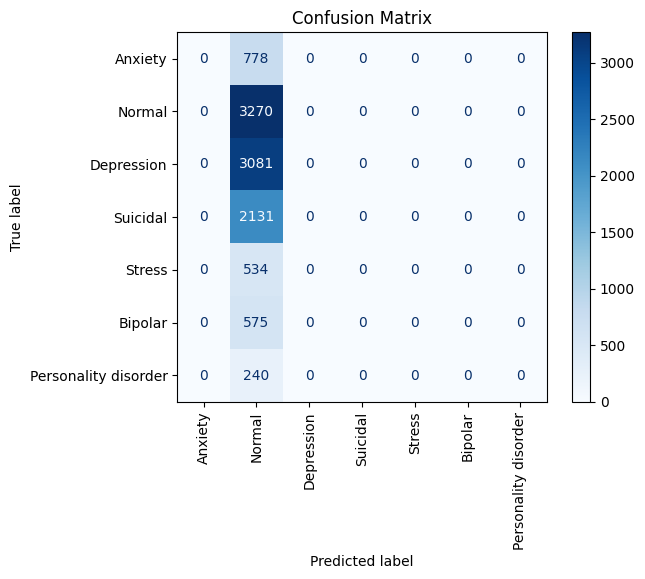

In [21]:
conf_matrix = confusion_matrix(test_labels, np.argmax(test_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_map.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.savefig('figures/pretrained-mental-bert-confmatrix.png')

# Дообучение модели

In [11]:
# Инициализация токенизатора и модели
MODEL_NAME = "mental/mental-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_map),
    id2label={v: k for k, v in label_map.items()},
    label2id=label_map
).to(device)

/home/student/kholicheva/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Параметры обучения
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

# Создание DataLoader
train_dataset = MentalHealthDataset(train_df["cleaned_text"], train_df["label"], tokenizer, MAX_LENGTH)
test_dataset = MentalHealthDataset(test_df["cleaned_text"], test_df["label"], tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Настройка оптимизатора
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [13]:
# Обучение модели
train_model(EPOCHS, model, train_loader, device, optimizer, scheduler)

100%|██████████| 2653/2653 [07:23<00:00,  5.98it/s]


Эпоха 1/3
Средний лосс: 0.5701


100%|██████████| 2653/2653 [07:23<00:00,  5.99it/s]


Эпоха 2/3
Средний лосс: 0.3713


100%|██████████| 2653/2653 [07:23<00:00,  5.98it/s]

Эпоха 3/3
Средний лосс: 0.2758


In [14]:
# Оценка модели
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Вывод метрик
print("\nРезультаты классификации:")
report = compute_metrics(test_preds, test_labels)
print(report)

# Сохранение модели
model.save_pretrained("mental_health_classifier")
tokenizer.save_pretrained("mental_health_classifier")
print("Модель сохранена в 'mental_health_classifier'")

100%|██████████| 664/664 [00:38<00:00, 17.10it/s]



Результаты классификации:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.87      0.86       778
              Normal       0.96      0.95      0.96      3270
          Depression       0.81      0.77      0.79      3081
            Suicidal       0.72      0.77      0.75      2131
              Stress       0.73      0.78      0.75       534
             Bipolar       0.82      0.85      0.84       575
Personality disorder       0.79      0.68      0.73       240

            accuracy                           0.84     10609
           macro avg       0.81      0.81      0.81     10609
        weighted avg       0.84      0.84      0.84     10609

Модель сохранена в 'mental_health_classifier'


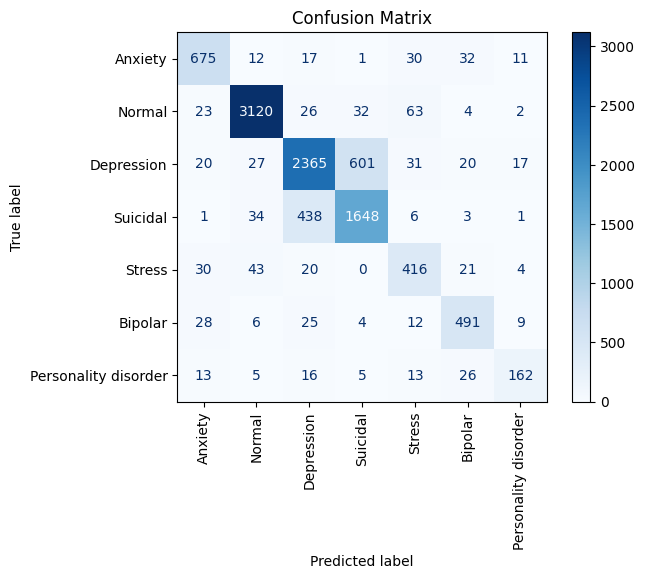

In [18]:
conf_matrix = confusion_matrix(test_labels, np.argmax(test_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_map.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.savefig('figures/mental-bert-confmatrix.png')

# Использование модели

In [22]:
# Пример использования сохраненной модели
def predict_mental_health(text):  
    classifier = AutoModelForSequenceClassification.from_pretrained("mental_health_classifier").to(device)
    tokenizer = AutoTokenizer.from_pretrained("mental_health_classifier")
    
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = classifier(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        
    return {
        "label": classifier.config.id2label[pred_idx],
        "confidence": probs[pred_idx],
        "probabilities": {classifier.config.id2label[i]: float(probs[i]) for i in range(len(probs))}
    }

In [23]:
test_texts = [
    "I've been feeling really down lately, can't find joy in anything",
    "I am very tired because of the huge amount of things to do at school and work. A week of exams. I sit at my computer from morning till night. Some kind of feeling consumes me from the inside and makes me doubt myself.",
    "I've been falling asleep for a very long time lately, and a ton of thoughts are running around in my head and won't subside.",
    "I hate everybody around me.....",
    "There are always thoughts in my head. I can't stop thinking. My hands started shaking in class yesterday.",
    "I'm sweating and my hands are shaking, it feels like everyone is laughing at me.",
    "Tomorrow, at midnight. I will put an end to this suffering. I will be free.",
    "Today was a difficult day for me - I defended my diploma. but everything worked out for me and the commission liked the work.",
    "I want to gorge on pears."
]

for text in test_texts:
    result = predict_mental_health(text)
    print(f"\nПредсказание для текста: '{text}'")
    print(f"Статус: {result['label']} (уверенность: {result['confidence']:.2f})")


Предсказание для текста: 'I've been feeling really down lately, can't find joy in anything'
Статус: Depression (уверенность: 0.98)

Предсказание для текста: 'I am very tired because of the huge amount of things to do at school and work. A week of exams. I sit at my computer from morning till night. Some kind of feeling consumes me from the inside and makes me doubt myself.'
Статус: Stress (уверенность: 0.62)

Предсказание для текста: 'I've been falling asleep for a very long time lately, and a ton of thoughts are running around in my head and won't subside.'
Статус: Stress (уверенность: 0.87)

Предсказание для текста: 'I hate everybody around me.....'
Статус: Suicidal (уверенность: 0.64)

Предсказание для текста: 'There are always thoughts in my head. I can't stop thinking. My hands started shaking in class yesterday.'
Статус: Stress (уверенность: 0.75)

Предсказание для текста: 'I'm sweating and my hands are shaking, it feels like everyone is laughing at me.'
Статус: Stress (уверенно